# Lecture 19 - Adiabatic reactors

In [1]:
# First import some libraries
#%matplotlib notebook 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy
import scipy.integrate
import scipy.optimize

In [2]:
# This cell just tries to make graphs look nicer
try:
    import seaborn as sns
except ImportError:
    # This block will be run if there's an ImportError, i.e you don't have seaborn installed.
    sns = False
    print ("If you want to try different figure formatting, "
           "type 'conda install seaborn' at an anaconda command prompt or terminal. "
           "See https://stanford.edu/~mwaskom/software/seaborn/ for details")
    # If not using seaborn, we can still control the size of the figures this way
    from pylab import rcParams
    rcParams['figure.figsize'] = 6, 4
else:
    # This block will be run if there is no ImportError
    sns.set_style("ticks")
    sns.set_context("poster",rc={"figure.figsize": (6, 4)})

# Equilibrium conversion for adiabatic reactions
$$\require{mhchem}$$
Imagine a reversible reaction
$$\ce{ A <=> B}$$
with $\Delta H^\circ_{rxn}$ = -20 kcal/mol (exothermic) and 
$K_C$ = 100,000 (lies far to the right) at 298 K.

Use the van 't Hoff equation from your formula sheet to find $K_C(T)$ and hence equilibrium conversion $X_{e}(T)$.
$$
\ln\left( \frac{K_{C2}}{K_{C1}}\right) = \frac{-\Delta H^\circ_\text{rxn}}{R} \left(\frac{1}{T_2} - \frac{1}{T_1}\right)
$$

![Van 't Hoff](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Vant_Hoff.jpg/180px-Vant_Hoff.jpg)

In [3]:
molar_gas_constant = 1.987 # cal/mol/K
K_at_298 = 1e5 # dimensionless
DeltaH_Rx = -20e3 # cal/mol

def Kc(T):
    "Equilibrium constant Kc as a function of Temperature"
    K = K_at_298 * np.exp(( -1* DeltaH_Rx / molar_gas_constant) * (1./T - 1./298.) )
    return K

# Check it gives the right Kc at 298K
assert Kc(298) == K_at_298 

In [4]:
Kc(500) # should be lower, by le Chatellier's principle

0.11850278068783959

At equilibrium
\begin{align*}
k_f C_A &= k_r C_B \\
K_C &= \frac{k_f}{k_r} = \frac{C_{B,eq}}{C_{A,eq}} \\
 &= \frac{C_{A0} X_e}{C_{A0}(1 - X_e)} = \frac{X_e}{1 - X_e}\\
K_C - K_C X_e &= X_e \\
K_C &= X_e (K_C + 1) \\
X_e &= \frac{K_C}{K_C + 1}
\end{align*}

In [5]:
# Xe as a function of T
def Xe(T):
    K = Kc(T)
    X = K / (1 + K)
    return X
Xe(298.) # should be between 0 and 1, probably close to 1 with Kc so high (1e5)

0.99999000009999905

In [6]:
# X energy balance as a function of T
def Xeb(T):
    CpA = 50. # cal/mol/K
    T0 = 300. # K. Feed temperature
    X = CpA * (T - T0) / (-1* DeltaH_Rx)
    return X
Xeb(500.)

0.5

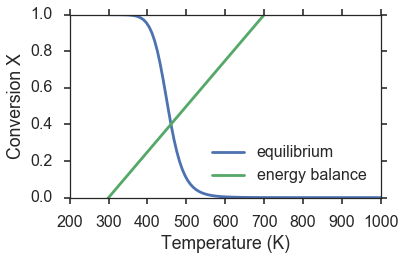

In [7]:
temperatures = np.linspace(298,1000,100)
plt.plot(temperatures, Xe(temperatures), label='equilibrium')
plt.plot(temperatures, Xeb(temperatures), label='energy balance')
plt.xlabel('Temperature (K)')
plt.ylabel('Conversion X')
plt.ylim((0,1.))
plt.legend(loc='best')
plt.tight_layout()

Use `scipy.optimize.root` to find exactly the temperature where they are equal: 


In [8]:
def thing_I_want_zero(T):
    return Xe(T) - Xeb(T)
result = scipy.optimize.root(thing_I_want_zero, 400)
print result
T = result.x[0]
print T
print Xeb(T)
print Xe(T)

    fjac: array([[-1.]])
     fun: array([  2.22044605e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([  1.38393075e-10])
       r: array([ 0.013906])
  status: 1
 success: True
       x: array([ 460.39964282])
460.399642821
0.400999107052
0.400999107052


# Example 11-3
$$\require{mhchem}$$
Normal butane, C<sub>4</sub>H<sub>10</sub>, is to be isomerized to isobutane in a plug-flow reactor, because isobutane is worth more. This elementary reversible reaction is to be carried out adiabatically in the liquid phase under high pressure using trace amounts of a liquid catalyst which gives a specific reaction rate of 31.1/hr at 360K. The feed enters at 330K. 

Additional information: 
* $\Delta H^\circ_{Rx} = -6900$ J/mol $n$-butane
* Activation energy $E_a = 65.7$ kJ/mol 
* $K_C = 3.03$ at $60^\circ$ C  
* $C_{P,n\text{-Butane}} = 141$ J/mol/K 
* $C_{P,i\text{-Butane}} = 141$ J/mol/K 
* $C_{P,n\text{-Pentane}} = 161$ J/mol/K
* $C_{A0} = 9.3$ mol/dm3 = 9.3 kmol/m3 feed concentration of n-butane

a) Calculate the PFR volume necessary to process 100,000 gal/day (163 kmol/h) at 70% conversion of a mixture of 90 mol% n-butane and 10 mol% i-pentane, which is considered an inert.

b) Plot and analyze $X, X_e, T$, and $-r_A$ down the length of the reactor.

c) Calculate the CSTR volume for 40% conversion.

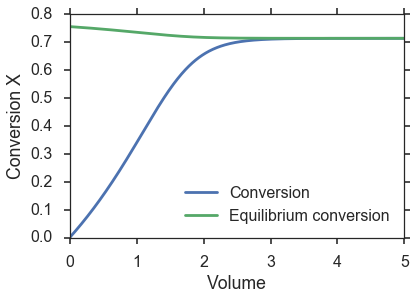

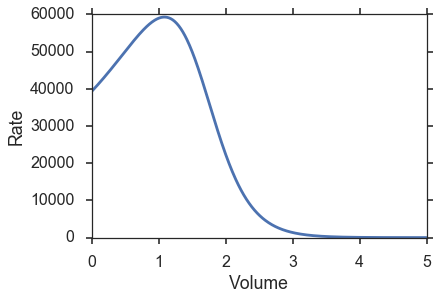

In [12]:
DHrx = -6900. # J/mol
Ea = 65700. # J/mol
R = 8.314 # J/mol/K
T0 = 330 # K
FA0 = 0.9 * 163e3 # mol/hr
CA0 = 9.3e3 # mol/m3

def Kc(T):
    "Equilibrium constant, as a function of temperature"
    return 3.03 * np.exp(( -1* DHrx / R) * (1./T - 1./(273.15+60)) )
assert Kc(273.15+60) == 3.03
assert Kc(273.15+65) < 3.03 # le Chatellier's principle

def k(T):
    "Specific reaction rate in 1/hour, as a function of temperature"
    return 31.1 * np.exp((-1*Ea/R) * (1./T - 1./360.))
assert k(360) == 31.1
assert k(365) > 31.1

def Teb(X):
    "Temperature from energy balance, as a function of conversion."
    Cps = np.array([141, 141, 161])
    Thetas = np.array([1., 0., 0.1/0.9])
    return T0 - DHrx * X / sum(Cps*Thetas)
assert Teb(0) == T0
assert Teb(0.5) > T0 # Exothermic

def dXdV(X,V):
    """
    dX/dV in a plug flow reactor is -rA/ FA0
    """
    T = Teb(X)
    CA = CA0*(1.-X)
    CB = CA0*X
    rA = -k(T)*(CA - CB/Kc(T))
    return -rA/FA0
    
volumes = np.linspace(0,5,501)
X = scipy.integrate.odeint(dXdV, 0., volumes)
plt.plot(volumes,X,label="Conversion")

Xeq = Kc(Teb(X))/ (1+Kc(Teb(X)))
plt.plot(volumes, Xeq,label="Equilibrium conversion")
plt.legend(loc="best")
plt.xlabel("Volume")
plt.ylabel("Conversion X")
plt.show()

rate = k(Teb(X))*(CA0*(1.-X) - CA0*X/Kc(Teb(X)))
plt.plot(volumes, rate, label="Rate")
plt.xlabel("Volume")
plt.ylabel("Rate")
plt.show()


In [10]:
for volume, conversion in zip(volumes, X):
    if conversion>0.7:
        break
print volume
print conversion

2.49
[ 0.70006821]


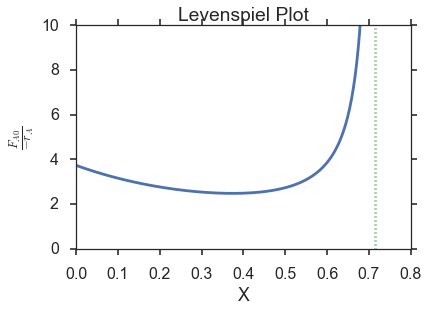

In [11]:
plt.plot(X, FA0/rate)
plt.ylim(0,10)
plt.title("Levenspiel Plot")
plt.xlabel("X")
plt.ylabel("$\\frac{F_{A0}}{-r_A}$")
plt.plot((Xeq[-1],Xeq[-1]),(0,FA0/rate[-1]), ':')
plt.show()